<a href="https://colab.research.google.com/github/QuangDuyxyz/Digital/blob/main/DSP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Giới thiệu thành viên:

**Nguyễn Quang Duy-20146240**

**Lê Quốc Cường-20146230**

Tài liệu tham khảo:

https://github.com/Xiaohan-Chen/bear_fault_diagnosis

https://github.com/malyvsen/bearing-fault-detection

https://github.com/Vardoom/PredictiveMaintenanceNASA




# Mô tả dữ liệu:

Tập dữ liệu bạn mô tả liên quan đến thử nghiệm độ bền của vòng bi và ghi lại các tín hiệu rung từ các vòng bi trong điều kiện hoạt động cụ thể. Dưới đây là tổng quan về tập dữ liệu này:

> Mục Đích Thử Nghiệm:

>> Thử nghiệm được thiết kế để mô phỏng điều kiện hoạt động của vòng bi và ghi lại dữ liệu về tín hiệu rung để phân tích độ bền và phát hiện các lỗi.

> Thiết lập Thử Nghiệm:

>> Bốn vòng bi Rexnord ZA-2115 được lắp trên một trục.
Trục quay với tốc độ không đổi là 2000 vòng/phút, sử dụng động cơ xoay chiều kết nối với trục qua đai chà.
Tải trọng xuyên tâm là 6000 lbs được áp dụng lên trục và vòng bi thông qua cơ cấu lò xo.
Các vòng bi được bôi trơn cưỡng bức để đảm bảo hoạt động ổn định.

> Cảm Biến và Thu Thập Dữ liệu:

>> Gia tốc kế ICP thạch anh PCB 353B33 với độ nhạy cao được lắp đặt trên vỏ của mỗi vòng bi.
Dữ liệu rung được thu thập qua hai gia tốc kế cho mỗi vòng bi (đo trên trục x và y) cho Bộ dữ liệu 1, và một gia tốc kế cho mỗi ổ trục cho Bộ dữ liệu 2 và 3.

> Cấu Trúc Tập Dữ liệu:

>> Gói dữ liệu bao gồm ba bộ dữ liệu, mỗi bộ mô tả một thử nghiệm từ bắt đầu đến khi thất bại.
Dữ liệu được ghi lại dưới dạng các ảnh chụp nhanh tín hiệu rung 1 giây, thu thập theo các khoảng thời gian cụ thể.
Mỗi tệp dữ liệu chứa 20.480 điểm dữ liệu với tốc độ lấy mẫu là 20 kHz.
Tên tệp phản ánh thời điểm thu thập dữ liệu.
Việc thu thập dữ liệu được thực hiện sử dụng Thẻ NI DAQ 6062E.

> Mục Đích và Ứng Dụng:

>> Tập dữ liệu này có thể được sử dụng để phân tích đặc tính rung động của vòng bi, phát hiện sớm lỗi và nghiên cứu tuổi thọ của vòng bi.
Nó cung cấp thông tin quý giá cho việc bảo trì dự đoán và cải tiến thiết kế vòng bi.

Khởi tạo môi trường Kaggle API:

> Mô tả: Script bắt đầu bằng việc thiết lập môi trường Kaggle API để tải xuống dữ liệu. Điều này bao gồm việc sao chép kaggle.json, cấp quyền, và cài đặt gói Kaggle.

> Đánh giá: Các lệnh được sử dụng đúng để thiết lập môi trường, nhưng cần chú ý rằng các lệnh này chỉ hoạt động trong môi trường Colab.

In [ ]:
#Tạo thư mục .kaggle:
!mkdir -p ~/.kaggle

In [ ]:

!cp "/content/kaggle (2).json" ~/.kaggle/

In [ ]:
# Thiết lập quyền cho file kaggle.json:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Copy the kaggle api json path
!cp "/content/kaggle (2).json" ~/.kaggle/kaggle.json

In [ ]:
#install the kaggle python package using pip
!python -m pip install -qq kaggle

In [ ]:
# Download the dataset from kaggle
!kaggle datasets download -d vinayak123tyagi/bearing-dataset

bearing-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzip the datasets file
!unzip -qq "/content/bearing-dataset.zip"

In [ ]:
!pip install tensorflow

Tải và cấu trúc lại dữ liệu:

> Mô tả: Dữ liệu được tải và cấu trúc lại từ nhiều tệp trong một thư mục, qua đó tối ưu hóa việc quản lý dữ liệu cho quá trình xử lý.

> Đánh giá: Hàm load_from_csv được thiết kế tốt, sử dụng os.listdir và pandas.read_csv để đọc dữ liệu hiệu quả.

In [ ]:
import os
import warnings
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
import pickle

# Set seeds for reproducibility
np.random.seed(0)
random.seed(0)
tf.random.set_seed(12345)



# Load data


Tải và cấu trúc lại dữ liệu từ nhiều tệp tin trong một thư mục, làm cho việc quản lý và xử lý dữ liệu trở nên hiệu quả hơn.

In [ ]:
def load_from_csv(DIR):
    '''
    Hàm trợ giúp để nạp tất cả dữ liệu từ một thư mục
    :param DIR: Thư mục để nạp dữ liệu từ
    :return x_values: Giá trị được đọc từ các tệp
    '''
    filenames = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]
    first_file = os.path.join(DIR, filenames[0])
    samples_per_row = len(pd.read_csv(first_file, sep="\t", nrows=1).columns)
    x_values = np.zeros([len(filenames), 20480, samples_per_row])
    filenames = sorted(filenames)

    for i, file in tqdm(enumerate(filenames), desc="Đang Đọc Dữ Liệu", ascii=False, ncols=100, total=len(filenames)):
        file_path = os.path.join(DIR, file)
        x_values[i:i+1, :, :] = np.fromfile(file_path, dtype=np.float, sep=" ").reshape(20480, samples_per_row)

    return x_values

In [ ]:
def load_raw_data(force=False):
    '''
    Nạp dữ liệu từ tất cả ba bộ dữ liệu nếu dữ liệu chưa được lưu dưới dạng tệp pickle,
    dữ liệu đã nạp sẽ được lưu vào các tệp pickle riêng biệt.
    Bởi vì việc nạp cả ba bộ dữ liệu vào bộ nhớ có thể tốn nhiều bộ nhớ.
    :param force: Xác định xem chương trình có bị buộc phải nạp lại dữ liệu từ các tệp csv và bỏ qua tệp pickle hiện có hay không.
    :return: Không có giá trị được trả về vì dữ liệu được lưu trong tệp pickle.
    '''
    DIRS = ['/content/1st_test/1st_test/',
            '/content/2nd_test/2nd_test/',
            '/content/3rd_test/4th_test/txt/',
           ]

    for i in range(3):
        pickle_filename = "test" + str(i) + ".pkz"
        if os.path.isfile(pickle_filename) and not force:
            print("Dữ liệu test", i, "đã được nạp trước đó.")
            continue

        x = load_from_csv(DIRS[i])
        with open(pickle_filename, "wb") as file:
            pickle.dump(x, file)

# Gọi hàm load_raw_data để nạp dữ liệu (chỉ cần gọi một lần khi cần)
load_raw_data(force=False)

Đang Đọc Dữ Liệu:   0%|                                                    | 0/2156 [00:00<?, ?it/s]<ipython-input-12-0ffd2f75804f>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_values[i:i+1, :, :] = np.fromfile(file_path, dtype=np.float, sep=" ").reshape(20480, samples_per_row)
Đang Đọc Dữ Liệu:   0%|                                                     | 0/984 [00:00<?, ?it/s]<ipython-input-12-0ffd2f75804f>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` he

# Tiền xử lí dữ liệu
Thực hiện phân tích Fourier nhanh (FFT) trên dữ liệu thô và sau đó chia dữ liệu FFT thành các khoảng (bins), lấy giá trị trung bình trong mỗi khoảng.

> bins: Các giới hạn để chia dữ liệu FFT.

> raw_data: Dữ liệu thô để phân tích và sau đó được chia thành các bins.

> Cách Thức Hoạt Động:

>> Hàm tính FFT cho mỗi tần số trong raw_data.

>> Sau đó, nó sắp xếp giá trị FFT vào các bins đã định trước và tính trung bình của mỗi bin.

>> Kết quả trả về là mảng giá trị trung bình cho mỗi bin.

In [ ]:
def binning(bins, raw_data):
    '''
    Lấy các giá trị raw_data và tính toán phân tích fft của chúng. Sau đó chia dữ liệu fft thành các thùng và lấy giá trị trung bình của mỗi thùng.
    :param bins: Các khoảng thùng để chia dữ liệu
    :param raw_data: Dữ liệu gốc cần phân tích và đưa vào thùng
    :return: Các giá trị cho mỗi thùng có hình dạng: (số lượng dòng thử nghiệm, số lượng vòng bi, số lượng thùng)
    '''
    num_rows = raw_data.shape[0]
    num_bearings = raw_data.shape[2]
    num_bins = len(bins) - 1
    values = np.zeros((num_rows, num_bearings, num_bins))

    for j in tqdm(range(num_bearings), desc="Đang Chia Dữ Liệu", ascii=True, ncols=100):
        f = np.fft.fft(raw_data[:, :, j])
        freq = np.fft.fftfreq(20480) * 20000

        for i in range(num_bins):
            bin_mask = (freq > bins[i]) & (freq <= bins[i + 1])
            values[:, j, i] += np.absolute(f[:, bin_mask]).mean(axis=1)

    return values

Tạo ra các đặc trưng từ dữ liệu thô, bao gồm các giá trị cực đại, độ lệch chuẩn, và các bins tần số.

> Cách Thức Hoạt Động:

>> Hàm xử lý dữ liệu thô, tùy chỉnh nó nếu cần (ví dụ, bỏ qua một số giá trị trong trường hợp cụ thể).

>> Nó sử dụng hàm binning để tạo các bins tần số.

>> Tính giá trị cực đại và độ lệch chuẩn cho mỗi vòng bi.

>> Kết quả cuối cùng là một mảng gồm các đặc trưng đã được kỹ thuật hóa.

In [ ]:
def feature_engineering(raw_data):
    '''
    Mục Đích của Hàm: Hàm này được sử dụng để tạo ra các đặc trưng kỹ thuật từ dữ liệu thô cho mỗi bạc đạn.
    Các đặc trưng này bao gồm giá trị tối đa, độ lệch chuẩn và các bin tần suất.

    Xử Lý Dữ liệu Thí Nghiệm: Trong "thí nghiệm 1", mỗi bạc đạn được đo lường hai giá trị.
    Tuy nhiên, mọi giá trị khác được loại bỏ để đảm bảo rằng các thí nghiệm có thể so sánh với nhau.

    Đầu vào của Hàm: Tham số raw_data là dữ liệu thô mà từ đó các đặc trưng được kỹ thuật hóa.

    Đầu ra của Hàm: Hàm trả về các giá trị đã được kỹ thuật hóa với hình dạng
    (độ dài của thí nghiệm, số lượng bạc đạn nhân với số lượng đặc trưng đã kỹ thuật hóa).
    '''
    if raw_data.shape[2] == 8:
        raw_data = raw_data[:, :, [0, 2, 4, 6]]

    bins = np.array([0, 250, 1000, 2500, 5000, 10000])
    values = binning(bins, raw_data)
    maxs = np.expand_dims(np.abs(raw_data).max(axis=1), 2)
    stds = np.expand_dims(raw_data.std(axis=1), 2)
    values = np.concatenate((maxs, stds, values), axis=2)

    values = np.swapaxes(values, 1, 2)
    values = values.reshape((values.shape[0], values.shape[1] * values.shape[2]))

    return values, bins

Tải dữ liệu thô từ các tệp tin pickle, sau đó áp dụng kỹ thuật tạo đặc trưng trên dữ liệu đó.

> force: Tham số này quyết định liệu hàm có nên tạo đặc trưng lại mặc dù đã có tệp tin data.pkz tồn tại hay không.

> Cách Thức Hoạt Động:

>> Kiểm tra xem tệp tin data.pkz đã tồn tại chưa. Nếu có và force là False, nó chỉ tải dữ liệu từ pickle.

>> Nếu không, hàm tải dữ liệu thô từ các tệp tin test{i}.pkz, áp dụng feature_engeneering lên dữ liệu này, và sau đó lưu kết quả vào data.pkz.

In [ ]:
def load_data(force=False):
    '''
    Đoạn mã này tải dữ liệu thô từ các tệp pickle và sau đó kỹ thuật hóa các đặc trưng từ dữ liệu đó.
    Nếu tệp data.pkz đã tồn tại, nó chỉ đơn giản tải tệp pickle này.
    :param force: Buộc hàm phải kỹ thuật hóa lại các đặc trưng dù tệp data.pkz đã tồn tại.
    :return data: Dữ liệu với các đặc trưng đã được kỹ thuật hóa cho mỗi bài thử nghiệm có hình dạng:
    ((độ dài của bài thử nghiệm 1, số lượng bạc đạn * số lượng các đặc trưng đã được kỹ thuật hóa),
    (độ dài của bài thử nghiệm 2, số lượng bạc đạn * số lượng các đặc trưng đã được kỹ thuật hóa),
    (độ dài của bài thử nghiệm 3, số lượng bạc đạn * số lượng các đặc trưng đã được kỹ thuật hóa))
    '''
    if "data.pkz" in os.listdir(".") and not force:
        print("Dữ liệu đã được kỹ thuật hóa. Đang tải từ tệp pickle.")
        with open("data.pkz", "rb") as file:
            data = pickle.load(file)
    else:
        data = []
        for i in range(3):
            with open("test" + str(i) + ".pkz", "rb") as file:
                raw_data = pickle.load(file)
            values, bins = feature_engineering(raw_data)
            data.append(values)
        data = np.array(data)
        with open("data.pkz", "wb") as file:
            pickle.dump(data, file)
    return data

In [ ]:
data = load_data(force = False) # load data

Đang Chia Dữ Liệu: 100%|##############################################| 4/4 [00:25<00:00,  6.30s/it]
<ipython-input-17-c1982dde150d>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In ra số mẫu và đặc trưng của mẫu

In [ ]:
import pickle

ok = pickle.load(open("data.pkz", "rb"))
print(ok[2].shape)


(6324, 28)


# Biểu đồ mô tả giá trị trung bình của mỗi bins tần số

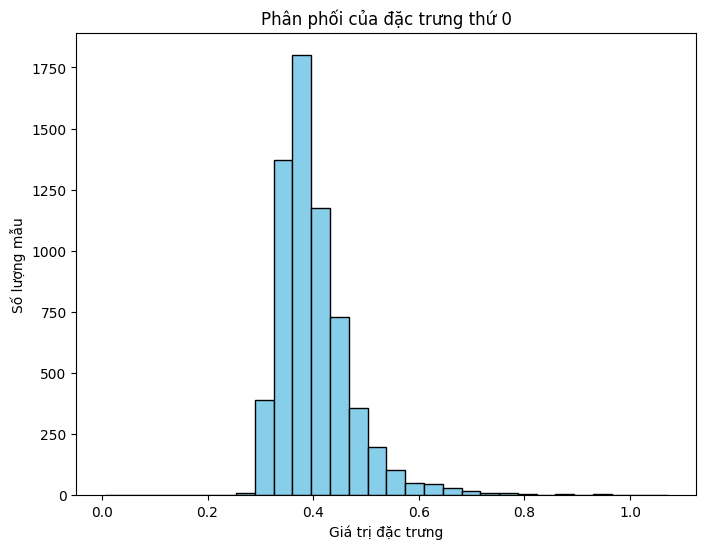

      0      1      2      3         4         5         6         7   \
0  0.569  0.527  0.361  0.303  0.079629  0.096641  0.066190  0.055323   
1  0.491  0.537  0.295  0.249  0.078512  0.091866  0.065984  0.052925   
2  0.515  0.596  0.286  0.278  0.079784  0.093403  0.069174  0.052606   
3  0.552  0.513  0.349  0.300  0.081042  0.092796  0.068599  0.054669   
4  0.381  0.562  0.388  0.247  0.079124  0.092826  0.067447  0.053804   
5  0.483  0.593  0.383  0.300  0.079535  0.093275  0.069780  0.053264   
6  0.461  0.579  0.605  0.337  0.080344  0.095210  0.069477  0.055232   
7  0.498  0.571  0.359  0.239  0.078458  0.092749  0.067004  0.053780   
8  0.527  0.720  0.354  0.293  0.080094  0.094895  0.070045  0.055174   
9  0.439  0.522  0.400  0.269  0.078301  0.094162  0.069328  0.054252   

          8          9   ...        18        19         20         21  \
0  13.081485  13.364545  ...  6.670448  4.810419  13.069640  13.629092   
1  12.457012  11.685861  ...  6.754867  5.077004

In [ ]:
import matplotlib.pyplot as plt

# Load dữ liệu từ tệp "data.pkz"
data = pickle.load(open("data.pkz", "rb"))

# Chuyển đổi dữ liệu thành DataFrame để dễ quản lý và mô tả
df = pd.DataFrame(data[2])  # Sử dụng data[2] hoặc data[0] hoặc data[1] tùy theo bạn muốn mô tả bài thử nghiệm nào

# Mô tả đặc điểm của dữ liệu bằng biểu đồ
# Ví dụ: Vẽ biểu đồ phân phối của một đặc trưng cụ thể (ví dụ: đặc trưng thứ 0)
plt.figure(figsize=(8, 6))
plt.hist(df[0], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Giá trị đặc trưng')
plt.ylabel('Số lượng mẫu')
plt.title('Phân phối của đặc trưng thứ 0')
plt.show()

# Mô tả đặc điểm của dữ liệu bằng bảng biểu
# Ví dụ: In ra 10 hàng đầu tiên của DataFrame
print(df.head(10))

# Mô tả thống kê tóm tắt của dữ liệu
# Ví dụ: Sử dụng describe() để xem thống kê tóm tắt của các đặc trưng
summary_stats = df.describe()
print(summary_stats)

# Chuẩn hóa dữ liệu

Sử dụng MinMaxScaler từ thư viện Scikit-Learn.

> data: Mảng dữ liệu cần được chuẩn hóa.

> test_size: Phần trăm dữ liệu sẽ được xem như là tập kiểm tra.


Hàm này chuẩn hóa toàn bộ dữ liệu nhưng chỉ sử dụng phần dữ liệu huấn luyện (không phải tập kiểm tra) để huấn luyện scaler.



In [ ]:
def scale(data,test_size=0.5, minmax=True):
    '''
    Hàm tính toán số lượng dữ liệu sẽ được sử dụng để "fit" (tìm các tham số cần thiết cho quá trình chuẩn hóa) dựa trên test_size.
    Hàm lựa chọn loại scaler dựa trên biến minmax.
    Sau đó, scaler được "fit" (được thiết lập) với một phần của dữ liệu (dựa trên l, số lượng dữ liệu không thuộc tập kiểm tra).
    Cuối cùng, scaler được áp dụng để chuyển đổi toàn bộ dữ liệu (data) thành dữ liệu đã được chuẩn hóa.
    :param data: Dữ liệu cần chuẩn hóa
    :param test_size: Tỷ lệ dữ liệu sẽ được sử dụng cho kiểm tra
    :param minmax: True nếu sử dụng MinMaxScaler, False nếu sử dụng StandardScaler
    :return values: Dữ liệu đã được chuẩn hóa
    '''
    l = int(data.shape[0]*(1-test_size))
    if minmax:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    scaler.fit(data[:l])
    values = scaler.transform(data)
    return values

# Huấn luyện mô hình


Mục tiêu:

> Tạo ra các chuỗi từ dữ liệu mà không sử dụng kỹ thuật padding.

Tham số:

> data: Dữ liệu từ đó chuỗi sẽ được tạo ra.

> seq_len: Độ dài của mỗi chuỗi (phải là số nguyên).

Mô tả chi tiết:

> Hàm này tạo ra các chuỗi bằng cách cắt dữ liệu thành các đoạn có độ dài seq_len.

> Mảng X được khởi tạo với các giá trị không và sau đó được điền từ dữ liệu.

> Mảng y là dữ liệu nguyên thủy được cắt theo các chuỗi.

In [ ]:
def generate_sequences_no_padding(data, seq_len):
    '''
    Khởi tạo mảng
    Vòng lặp để tạo chuỗi
    Điền dữ liệu vào mảng
    Khởi tạo mảng và trả về một mảng chứa dữ liệu và một mảng chứa dữ liệu mục tiêu tương ứng
    '''
    X = np.zeros([data.shape[0]-seq_len, seq_len, data.shape[1]])
    for i in tqdm(range (0,seq_len),  desc="Generating sequences",  ascii=True, ncols=100):
        X[:,i,:] = data[i:-seq_len+i,:]
    y = data[seq_len:,:]
    return X,y

Mục tiêu:

> Tạo ra các chuỗi từ dữ liệu với việc padding giá trị 0 ở phía trước.

Tham số:

> data: Dữ liệu từ đó chuỗi sẽ được tạo ra.

> seq_len: Độ dài của mỗi chuỗi (phải là số nguyên).

Mô tả chi tiết:

> Hàm này tạo ra các chuỗi bằng cách thêm giá trị 0 ở phía trước dữ liệu để tạo ra padding.

> Mảng X được khởi tạo với các giá trị không và sau đó được điền từ dữ liệu.

> Mảng y là dữ liệu nguyên thủy không được cắt, nhưng được sử dụng để đưa ra giá trị dự đoán.




In [ ]:
def generate_sequences_pad_front(data, seq_len):
    '''
    generates sequences from data with padding zeros in front
    :param data: data from which the sequence should be generated
    :param seq_len: length of each sequence (must be int)
    :return X: sequences stored in an array with shape:
            (length of test, sequence length, number of bearings*number of features engineered)
    :return y: values to be predicted. Next value after each sequence has shape:
            (length of test, number of bearings*number of features engineered)
    '''
    X = np.zeros([data.shape[0], seq_len, data.shape[1]])
    d =  np.pad(data, ((seq_len,0),(0,0)), 'constant')
    for i in tqdm(range (0,seq_len),  desc="Generating sequences",  ascii=True, ncols=100):
        X[:,i,:] = d[i:-seq_len+i,:]
    y = data[:,:]
    return X,y

Mục tiêu:

> Chia tập dữ liệu thành tập huấn luyện và tập kiểm thử.

Tham số:

> X: Dữ liệu để chia thành X_train và X_test.

> y: Dữ liệu để chia thành y_train và y_test.

> test_size: Phần trăm dữ liệu sẽ nằm trong tập kiểm thử.

Mô tả chi tiết:

> Hàm này sử dụng test_size để xác định vị trí cắt giữa tập huấn luyện và tập kiểm thử.

> Dữ liệu được chia thành bốn phần: X_train, X_test, y_train, y_test.

In [ ]:
def split_data_set(X,y, test_size = 0.5):
    '''
    splits data set into train and test set
    :param X: data to spilt for X_train and X_test
    :param y: data to spilt for y_train and y_test
    :param test_size: percentage of data that should be in the test sets
    :return X_train, X_test, y_train, y_test: X and y values for train and test
    '''
    length = X.shape[0]
    X_train = X[:int(-length*test_size)]
    y_train = y[:int(-length*test_size)]
    X_test = X[int(-length*test_size):]
    y_test = y[int(-length*test_size):]
    return X_train, X_test, y_train, y_test

Mục tiêu:

> Chuẩn bị dữ liệu cho việc huấn luyện mô hình trong nhiều lần kiểm thử.

Tham số:

> data: Dữ liệu sẽ được sử dụng để tạo ra các tập kiểm thử và tập huấn luyện.

> seq_len: Độ dài của mỗi chuỗi (phải là số nguyên).

> test_size: Phần trăm dữ liệu sẽ nằm trong tập kiểm thử.

Mô tả chi tiết:

> Hàm này lặp qua từng bộ dữ liệu trong data, thực hiện việc chia tỷ lệ và tạo chuỗi không padding.

> Kết quả được tổ chức thành các mảng X_train_series, X_test_series, y_train, y_test.

> Có thêm khả năng huấn luyện trên tất cả các bộ kiểm thử cùng một lúc, với giá trị được lưu trữ trong X_train_series[3] và y_train[3].

In [ ]:
def prepare_data_series(data, seq_len, test_size=0.5):
    prepared_data = []
    X_train_series_list = []
    X_test_series_list = []
    y_train_list = []
    y_test_list = []

    for d in data:
        scaled_data = scale(d, test_size=test_size, minmax=True)
        if scaled_data is not None:
            X_series, y_series = generate_sequences_no_padding(scaled_data, seq_len)
            X_train, X_test, y_train, y_test = split_data_set(X_series, y_series, test_size)

            prepared_data.append((X_train, X_test, y_train, y_test))
            X_train_series_list.append(X_train)
            X_test_series_list.append(X_test)
            y_train_list.append(y_train)
            y_test_list.append(y_test)
        else:
            print("Error scaling data for one of the tests. Skipping.")

    X_train_series = np.array(X_train_series_list)
    X_test_series = np.array(X_test_series_list)
    y_train = np.array(y_train_list)
    y_test = np.array(y_test_list)

    return X_train_series, X_test_series, y_train, y_test


**Chia tỷ lệ dữ liệu:**

> Sử dụng hàm scale để chia tỷ lệ ba tập dữ liệu trong biến data với mức độ kiểm thử được xác định bởi test_size và sử dụng MinMaxScaler.

**Định nghĩa thông tin cho việc sắp xếp và biểu đồ:**

> Định nghĩa khoảng (bins) để sắp xếp tần suất dữ liệu vào.

> Đặt tên cho các bài kiểm tra trong biến test_names.

> Xây dựng một danh sách data_about_tests chứa thông tin chi tiết về mỗi bài kiểm tra, bao gồm tên, độ dài và vị trí của vòng bi hỏng.

In [ ]:
test_size = 0.6  # Định nghĩa kích thước của tập kiểm tra

# Chuẩn hóa dữ liệu cho từng bài kiểm tra và lưu vào danh sách data_scaled
data_scaled = []
for i, d in enumerate(data):
    scaled_data = scale(d, test_size=test_size, minmax=True)
    if scaled_data is not None:
        data_scaled.append(scaled_data)
    else:
        print(f"Error scaling data for test {i}. Skipping.")

# Định nghĩa khoảng tần số (bins) để phân loại các tần số
bins = np.array([0, 250, 1000, 2500, 5000, 10000])

# Định nghĩa tên cho các bài kiểm tra
test_names = ["1st", "2nd", "3rd"]

# Định nghĩa thông tin về các bài kiểm tra để hiển thị trong biểu đồ
data_about_tests = [
    {"name": "1st", "length": 2156, "broken": [2, 3]},
    {"name": "2nd", "length": 984, "broken": [0]},
    {"name": "3rd", "length": 6324, "broken": [2]}
]


Tiền xử lý dữ liệu chuỗi thời gian, chia nó thành bộ dữ liệu huấn luyện và kiểm thử, sau đó tái cấu trúc nó để sử dụng trong Mạng Nơ-ron Tích chập 3D, thường được sử dụng trong học sâu cho các tác vụ như nhận dạng video, hình ảnh y tế, hoặc bất kỳ ứng dụng nào mà dữ liệu có cấu trúc ba chiều.

In [ ]:
seq_len = 30
X_train_series, X_test_series, y_train, y_test = prepare_data_series(data, seq_len, test_size=test_size)

subsequences = 5
timesteps = seq_len // subsequences

X_train_series_sub = np.array([X_train_series[i].reshape((X_train_series[i].shape[0], subsequences, timesteps, X_train_series[i].shape[2] // subsequences, 4, 1)) for i in range(4)])

X_test_series_sub = np.array([X_test_series[i].reshape((X_test_series[i].shape[0], subsequences, timesteps, X_train_series[i].shape[2] // subsequences, 4, 1)) for i in range(3)])

print('Hình dạng tập huấn luyện:', [X_train_series_sub[i].shape for i in range(4)])
print('Hình dạng tập kiểm tra:', [X_test_series_sub[i].shape for i in range(3)])


Mô hình CNN-LSTM là một lựa chọn tốt cho việc xử lý dữ liệu chuỗi thời gian và có tiềm năng ứng dụng trong các tình huống thực tế đòi hỏi khả năng phát hiện bất thường cao.

Xử lí dữ liệu chuỗi thời gian phức tạp bằng mạng nơ-ron tích chập 3D (CNN) và Long Short-Term memory

In [ ]:
test = 3
cnn_lstm = Sequential()

# CNN được sử dụng để phân tích dữ liệu chuỗi thời gian
cnn_lstm.add(TimeDistributed(Conv3D(filters=70, kernel_size=(1, 2, 3), activation='relu'), input_shape=(X_train_series_sub[test].shape[1:])))
cnn_lstm.add(TimeDistributed(MaxPooling3D(pool_size=(X_train_series_sub[test].shape[2], 2, 3))))
cnn_lstm.add(TimeDistributed(Flatten()))

# LSTM
cnn_lstm.add(Dropout(0.3))  # Lớp Dropout được sử dụng để ngăn chặn overfitting, bỏ qua một số nơ-ron trong quá trình huấn luyện
cnn_lstm.add(LSTM(50))

cnn_lstm.add(Dense(y_train[test].shape[-1]))
cnn_lstm.compile(loss='mse', optimizer="adam")

cnn_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 6, 3, 5, 70)    490       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 1, 1, 1, 70)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 70)             0         
 stributed)                                                      
                                                                 
 dropout (Dropout)           (None, 5, 70)             0         
                                                                 
 lstm (LSTM)                 (None, 50)                24200     
                                                        

Huấn luyện

> Sử dụng một callback EarlyStopping để ngăn chặn quá trình huấn luyện nếu không thấy cải thiện đáng kể

In [ ]:
test=3
cnn_lstm.fit(X_train_series_sub[test] ,y_train[test] , epochs=150, batch_size=16, validation_split=0.3, verbose=1, shuffle = True,
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=70, verbose=0, mode='min',
                                   restore_best_weights=True)])

Epoch 1/150
165/165 [==============================] - 8s 9ms/step - loss: 0.0403 - val_loss: 0.0194
Epoch 2/150
165/165 [==============================] - 1s 5ms/step - loss: 0.0200 - val_loss: 0.0167
Epoch 3/150
165/165 [==============================] - 1s 6ms/step - loss: 0.0185 - val_loss: 0.0166
Epoch 4/150
165/165 [==============================] - 1s 5ms/step - loss: 0.0167 - val_loss: 0.0174
Epoch 5/150
165/165 [==============================] - 1s 6ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 6/150
165/165 [==============================] - 1s 6ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 7/150
165/165 [==============================] - 1s 8ms/step - loss: 0.0127 - val_loss: 0.0132
Epoch 8/150
165/165 [==============================] - 1s 7ms/step - loss: 0.0123 - val_loss: 0.0139
Epoch 9/150
165/165 [==============================] - 1s 8ms/step - loss: 0.0118 - val_loss: 0.0130
Epoch 10/150
165/165 [==============================] - 1s 8ms/step - loss: 0.0117 - val_lo

Vẽ dữ liệu theo các ô riêng biệt nếu không có ràng buộc nào khác được đặt, đây sẽ là một lưới gồm 4 cột và 7 hàng.

> Mỗi cột đại diện cho một ổ trục từ một lần chạy thử cụ thể. Mỗi hàng đại diện cho một tính năng được thiết kế.

> param y_true: dữ liệu thực được đo trong quá trình chạy thử sẽ được hiển thị màu xanh lam

> param bins: các tính năng đã được thiết kế. Trong trường hợp này nó sẽ là [max, std, 0Hz-250Hz, ... , 5000Hz-10000Hz]

> param data_about_tests: Từ điển chứa dữ liệu về lần chạy thử chứa key "broken"

> param y_pred: dữ liệu dự đoán sẽ được hiển thị màu cam

> param anomalies1: mảng boolean chứa giá trị True nếu cảnh báo dị thường1 được kích hoạt tại vị trí đó

> param anomalies2: mảng cho mỗi ổ trục chứa điểm dị thường2

> param cols: số cột bạn muốn vẽ phải tương đương với số vòng bi

> param seperate_legend: nếu bạn muốn có một chú giải riêng biệt bên ngoài cốt truyện, hãy đặt điều này thành True

> return fig: hình chứa tất cả các ô con nếu hình seperate_legend chỉ chứa chú giải cũng được trả về

In [ ]:
def plot(y_true, bins, data_about_tests, y_pred=np.array([]), anomalies1=np.array([]), anomalies2=np.array([]), cols=4, separate_legend=False):
    rows = y_true.shape[1] // cols

    fig = pylab.figure(figsize=(cols*4, rows*3))
    if separate_legend:
        figlegend = pylab.figure(figsize=(3, 2))

    axs = np.empty((rows, cols), dtype=object)
    axs2 = np.empty((rows, cols), dtype=object)

    y_position_of_title = 0.85
    labels = []
    lines = []
    ano1 = True
    for k in range(y_true.shape[-1]):
        i = k % cols
        j = k // cols
        axs[j, i] = fig.add_subplot(rows, cols, k+1, sharey=axs[j, 0])
        axs[j, i].tick_params(axis='y', labelcolor="tab:blue")

        lines.append(axs[j, i].plot(y_true[:, k])[0])
        labels.append("True_values" if j == 0 and i == 0 else "_True_values")

        if y_pred.size != 0:
            lines.append(axs[j, i].plot(y_pred[:, k])[0])
            labels.append("Predicted_values" if j == 0 and i == 0 else "_Predicted_values")

        if anomalies1.size != 0:
            w = 1.5
            for xc in np.arange(anomalies1.shape[0])[anomalies1[:, k]]:
                lines.append(axs[j, i].axvspan(xc-w, xc+w, facecolor="red", ymax=1, alpha=0.4))
                labels.append("Anomaly level 1 alarm" if ano1 else "_Anomaly1")
                ano1 = False
        if anomalies2.size != 0:
            axs2[j, i] = axs[j, i].twinx()  # instantiate a second axes that shares the same x-axis
            axs2[j, i].get_shared_y_axes().join(axs2[j, i], axs2[j, 0])
            color = 'black'
            lines.append(axs2[j, i].plot((anomalies2[:, k % cols]), color=color)[0])
            axs2[j, i].tick_params(axis='y', labelcolor=color)
            labels.append("Anomaly level 2 score" if j == 0 and i == 0 else "_Anomaly2")
        if j == 0:
            if i in data_about_tests["broken"]:
                axs[j, i].set_title("Bearing "+str(i)+"\nBreaks in the end\n\n Maximum Values", y=y_position_of_title)
            else:
                axs[j, i].set_title("Bearing "+str(i)+"\n\n\n Maximum Values", y=y_position_of_title)
        elif j == 1:
            axs[j, i].set_title("Standard Deviation", y=y_position_of_title)
        else:
            axs[j, i].set_title(str(bins[j-2])+"Hz-"+str(bins[j-2+1])+"Hz", y=y_position_of_title)
    if separate_legend:
        figlegend.legend(lines, labels, "center")
        return fig, figlegend
    else:
        fig.legend(lines, labels, bbox_to_anchor=(0.8, 0.96))
        return fig


Tính toán sai số giữa giá trị dự đoán và giá trị thực. Sau đó tính toán ranh giới xem sai số có thể khác bao nhiêu so với giá trị thực. Nếu lỗi vượt quá giới hạn đó, cảnh báo bất thường cấp một sẽ được lưu trữ.
 > Sau đó tính điểm bất thường cấp hai với tỷ lệ phần trăm của cảnh báo cấp một trong 30 dấu thời gian cuối cùng.

> param model: mô hình học máy được sử dụng để dự đoán

> param X: X_values được đưa vào mô hình để dự đoán

> param y_true: nhãn đúng cho dữ liệu trong X

> param test_size: kích thước của tập kiểm tra, quan trọng vì ranh giới chỉ được tính trên train_set

> param test_number: dữ liệu chạy thử được lấy từ đâu. Chỉ có thể là 0,1,2

> param slice_to_plot: nếu bạn chỉ muốn vẽ một phần nhất định của ô. ví dụ. nếu bạn chỉ muốn vẽ sơ đồ cuối cùng
                         1000 giá trị đặt giá trị này thành [-1000:] hoặc nếu bạn chỉ muốn vẽ biểu đồ mang 0, hãy đặt giá trị này thành [:,[0,4,8,12,16,20,24]]
                         và cũng đặt cols thành 1

> param anomaly_1_factor: bằng cách nhân độ lệch chuẩn để tính ranh giới

> param window_size: kích thước của cửa sổ dùng để tính điểm bất thường cấp hai

> param show_y_pred: thời tiết để hiển thị y_pred trong các ô

> param show_anomaly1: thời tiết để hiển thị các dị thường cấp một trong các ô

> param show_anomaly2: thời tiết để hiển thị điểm bất thường về mức độ trong các ô

 > param cols: bạn muốn vẽ bao nhiêu cột, phải là số góc bạn muốn vẽ

 > return fig: hình chứa các ô con

In [ ]:
def evaluate(model, X, y_true, test_size, test_number,slice_to_plot=np.s_[:], anomaly_1_factor = 5, window_size=30,
            show_y_pred=True, show_anomaly1 = True, show_anomaly2=True, cols=4):
    global data_about_tests
    train_size = int(X.shape[0]*(1-test_size))
    y_pred = model.predict(X, batch_size=10000)
    error = y_true-y_pred
    boundary = error[:train_size].mean(axis=0) + anomaly_1_factor*error[:train_size].std(axis=0)
    anomalies = error**2 > boundary
    anomalies2,_ = generate_sequences_pad_front(anomalies[slice_to_plot],window_size) #Always look at anomalies in window
    anomalies2 = anomalies2.reshape((anomalies2.shape[0],window_size, anomalies2.shape[-1]//cols,cols))

    anomalies2 = anomalies2.mean(axis=1)
    anomalies2 = anomalies2.mean(axis=1)
    print("2nd level alarm over 0.5:")
    [print(np.where(anomalies2[:,i]>0.5)[0][:10]) for i in range(cols)]
    fig = plot(y_true[slice_to_plot], bins, data_about_tests[test_number], y_pred[slice_to_plot] if show_y_pred else np.array([]),
        anomalies1 =  anomalies[slice_to_plot] if show_anomaly1 else np.array([]) , anomalies2 = anomalies2[:] if show_anomaly2 else np.array([]), cols=cols)
    fig.suptitle(data_about_tests[test_number]["name"]+"_test\nstd_factor: "+str(anomaly_1_factor)+"\nwindow_size:"+str(window_size), fontsize=20)
    return fig

# Đánh giá mô hình

Chuẩn Bị Dữ Liệu:

> test=0: Đặt chỉ số test là 0, có thể được sử dụng để chọn tập dữ liệu cụ thể từ các mảng nhiều chiều hoặc danh sách dữ liệu.

> X = np.concatenate((X_train_series_sub[test], X_test_series_sub[test])): Gộp dữ liệu huấn luyện và kiểm thử vào một mảng duy nhất X. Điều này tạo ra một tập dữ liệu tổng hợp chứa thông tin từ cả hai phần.

> y_true = np.concatenate((y_train[test], y_test[test])): Tương tự, gộp nhãn (labels) của dữ liệu huấn luyện và kiểm thử vào một mảng duy nhất y_true.

Bỏ Qua Cảnh Báo:

> with warnings.catch_warnings():: Bắt đầu một khối mã mà trong đó tất cả cảnh báo sẽ được xử lý đặc biệt.

> warnings.simplefilter("ignore"): Thiết lập để bỏ qua tất cả cảnh báo trong khối mã này. Điều này hữu ích khi bạn muốn tránh hiển thị cảnh báo không cần thiết hoặc gây phiền nhiễu từ thư viện hoặc mã nguồn.

Đánh Giá Mô Hình và Hiển Thị Kết Quả:

> fig = evaluate(...):
>> Gọi hàm evaluate đã được giải thích ở trên.
cnn_lstm: Mô hình để đánh giá.

>> X, y_true: Dữ liệu đầu vào và nhãn thực tế.

>> test_size, test: Thông số kích thước tập kiểm thử và chỉ số lần thử nghiệm.
slice_to_plot=np.s_[:]: Lựa chọn phần dữ liệu để vẽ biểu đồ (ở đây là toàn bộ dữ liệu).
anomaly_1_factor=3, window_size=30: Các thông số để xác định và tính toán bất thường.
show_y_pred, show_anomaly1, show_anomaly2: Các tùy chọn để hiển thị dự đoán của mô hình và cảnh báo bất thường trên biểu đồ.

Maximum values: Giá trị lớn nhất cho từng vòng bi trong từng khoảng thời gian. Là giá trị cực đại của lực, áp suất, nhiệt độ hoặc chỉ số rung động tại một thời điểm cụ thể.

Standard Deviation: Độ lệch chuẩn, một thước đo thống kê cho biết mức độ phân tán của một tập hợp các giá trị so với giá trị trung bình của chúng.

True_values: Các giá trị thực tế được đo lường từ cảm biến.

Predicted_values: Các giá trị dự đoán bởi mô hình

Anomaly level 1 alarm: Cảnh báo cấp độ 1 về bất thường, có lẽ được xác định khi các giá trị đo lường vượt qua một ngưỡng của độ lệch chuẩn.

Anomaly level 2 score: Điểm số cấp độ 2 cho bất thường, có thể chỉ ra mức độ nghiêm trọng hoặc xác suất của việc một bất thường là có hại hoặc cần được chú ý ngay lập tức.

1/1 [==============================] - 1s 621ms/step


Generating sequences: 100%|#######################################| 30/30 [00:00<00:00, 1618.84it/s]

2nd level alarm over 0.5:
[1862 1863 1864 1865 1866 1867 1868 1869 1870 1871]
[2102 2103 2104 2105 2106 2107 2108 2109 2110 2111]
[1672 1673 1674 1675 1676 1677 1678 1679 1680 1681]
[1605 1606 1607 1608 1609 1610 1611 1612 1613 1614]
Plotting


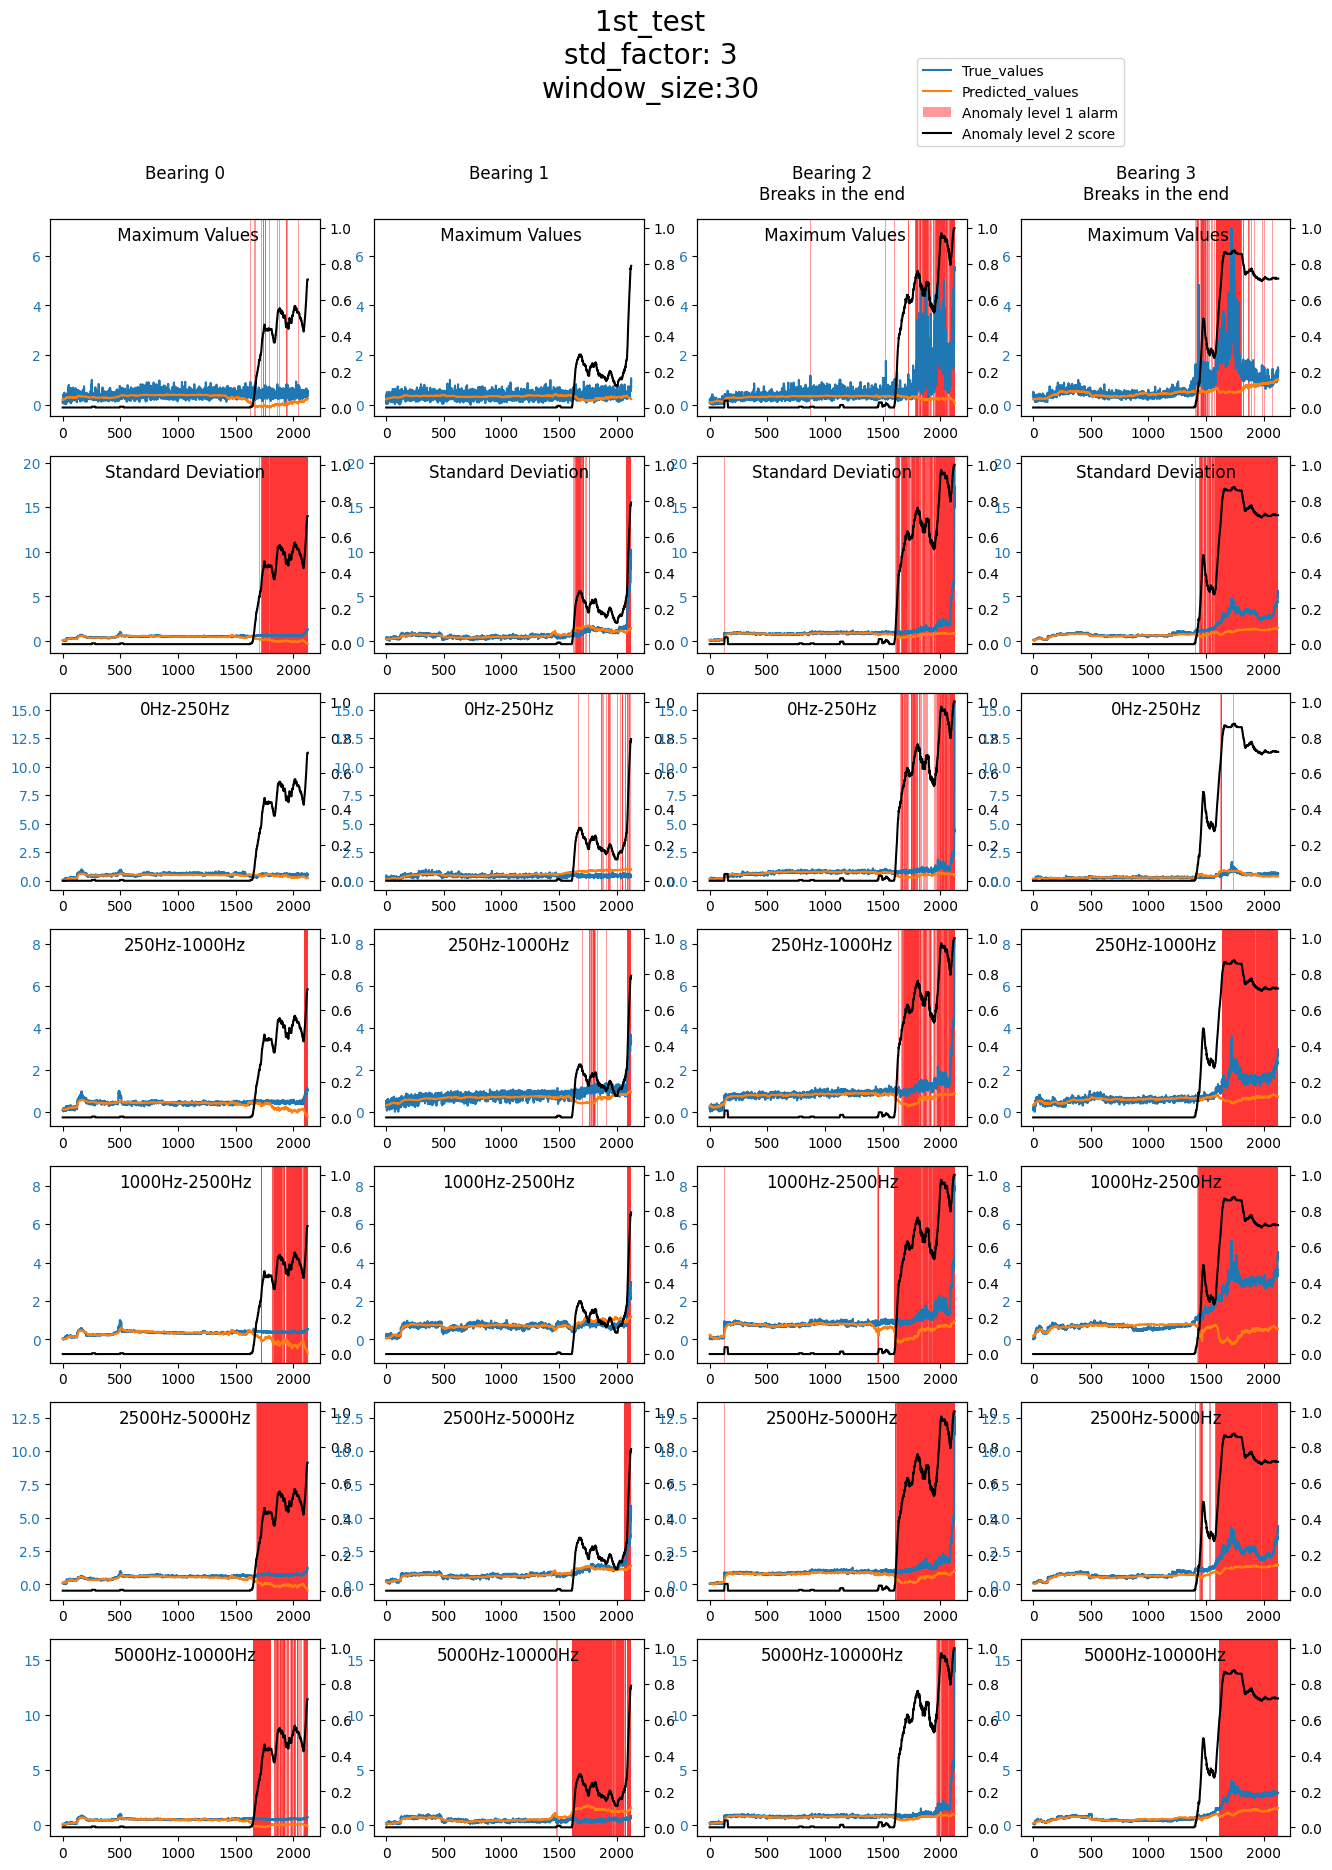

In [ ]:
test=0
X = np.concatenate((X_train_series_sub[test],X_test_series_sub[test]))
y_true = np.concatenate((y_train[test],y_test[test]))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = evaluate(cnn_lstm, X, y_true, test_size ,test, slice_to_plot=np.s_[:],anomaly_1_factor=3, window_size=30,
show_y_pred=True, show_anomaly1 = True, show_anomaly2 = True)

**Với data đầu tiên (test=0)**

Vòng bi 0 và Vòng bi 3: Có sự gia tăng đáng kể về giá trị tối đa và độ lệch chuẩn ở cuối dãy thời gian, trùng với khu vực được tô màu đỏ chỉ ra điểm bất thường cao. Điều này ngụ ý rằng có thể có vấn đề cơ khí hoặc hỏng hóc sắp xảy ra hoặc đã xảy ra tại những điểm này.
(Hư sẽ giao động nhanh -->> tần số cao nên vượt ngưỡng là hư)

Vòng bi 1 và Vòng bi 2: Có sự gia tăng nhẹ về điểm bất thường nhưng vẫn có thể quan sát thấy ở cuối dãy thời gian, đặc biệt là trong dải tần 0Hz-250Hz của Vòng bi 1.

Hệ thống phát hiện bất thường dường như kích hoạt báo động cấp độ 1 khi giá trị dự đoán lệch lớn so với giá trị thực tế, và điểm bất thường cấp độ 2 tổng hợp những này trên một cửa sổ thời gian, cung cấp chỉ số mượt mà hơn về sự kéo dài hoặc mức độ nghiêm trọng của bất thường.

Mô hình dự đoán hoạt động tốt trong những khoảng thời gian yên tĩnh nhưng có vẻ gặp khó khăn trong những giai đoạn biến động cao, điều này là điển hình trong phát hiện bất thường của dữ liệu chuỗi thời gian.

1/1 [==============================] - 0s 272ms/step


Generating sequences: 100%|#######################################| 30/30 [00:00<00:00, 5609.11it/s]

2nd level alarm over 0.5:
[679 680 681 682 683 684 685 686 687 688]
[895 896 897 898 899 900 901 902 903 904]
[]
[700 701 702 703 704 705 706 707 708 709]
Plotting


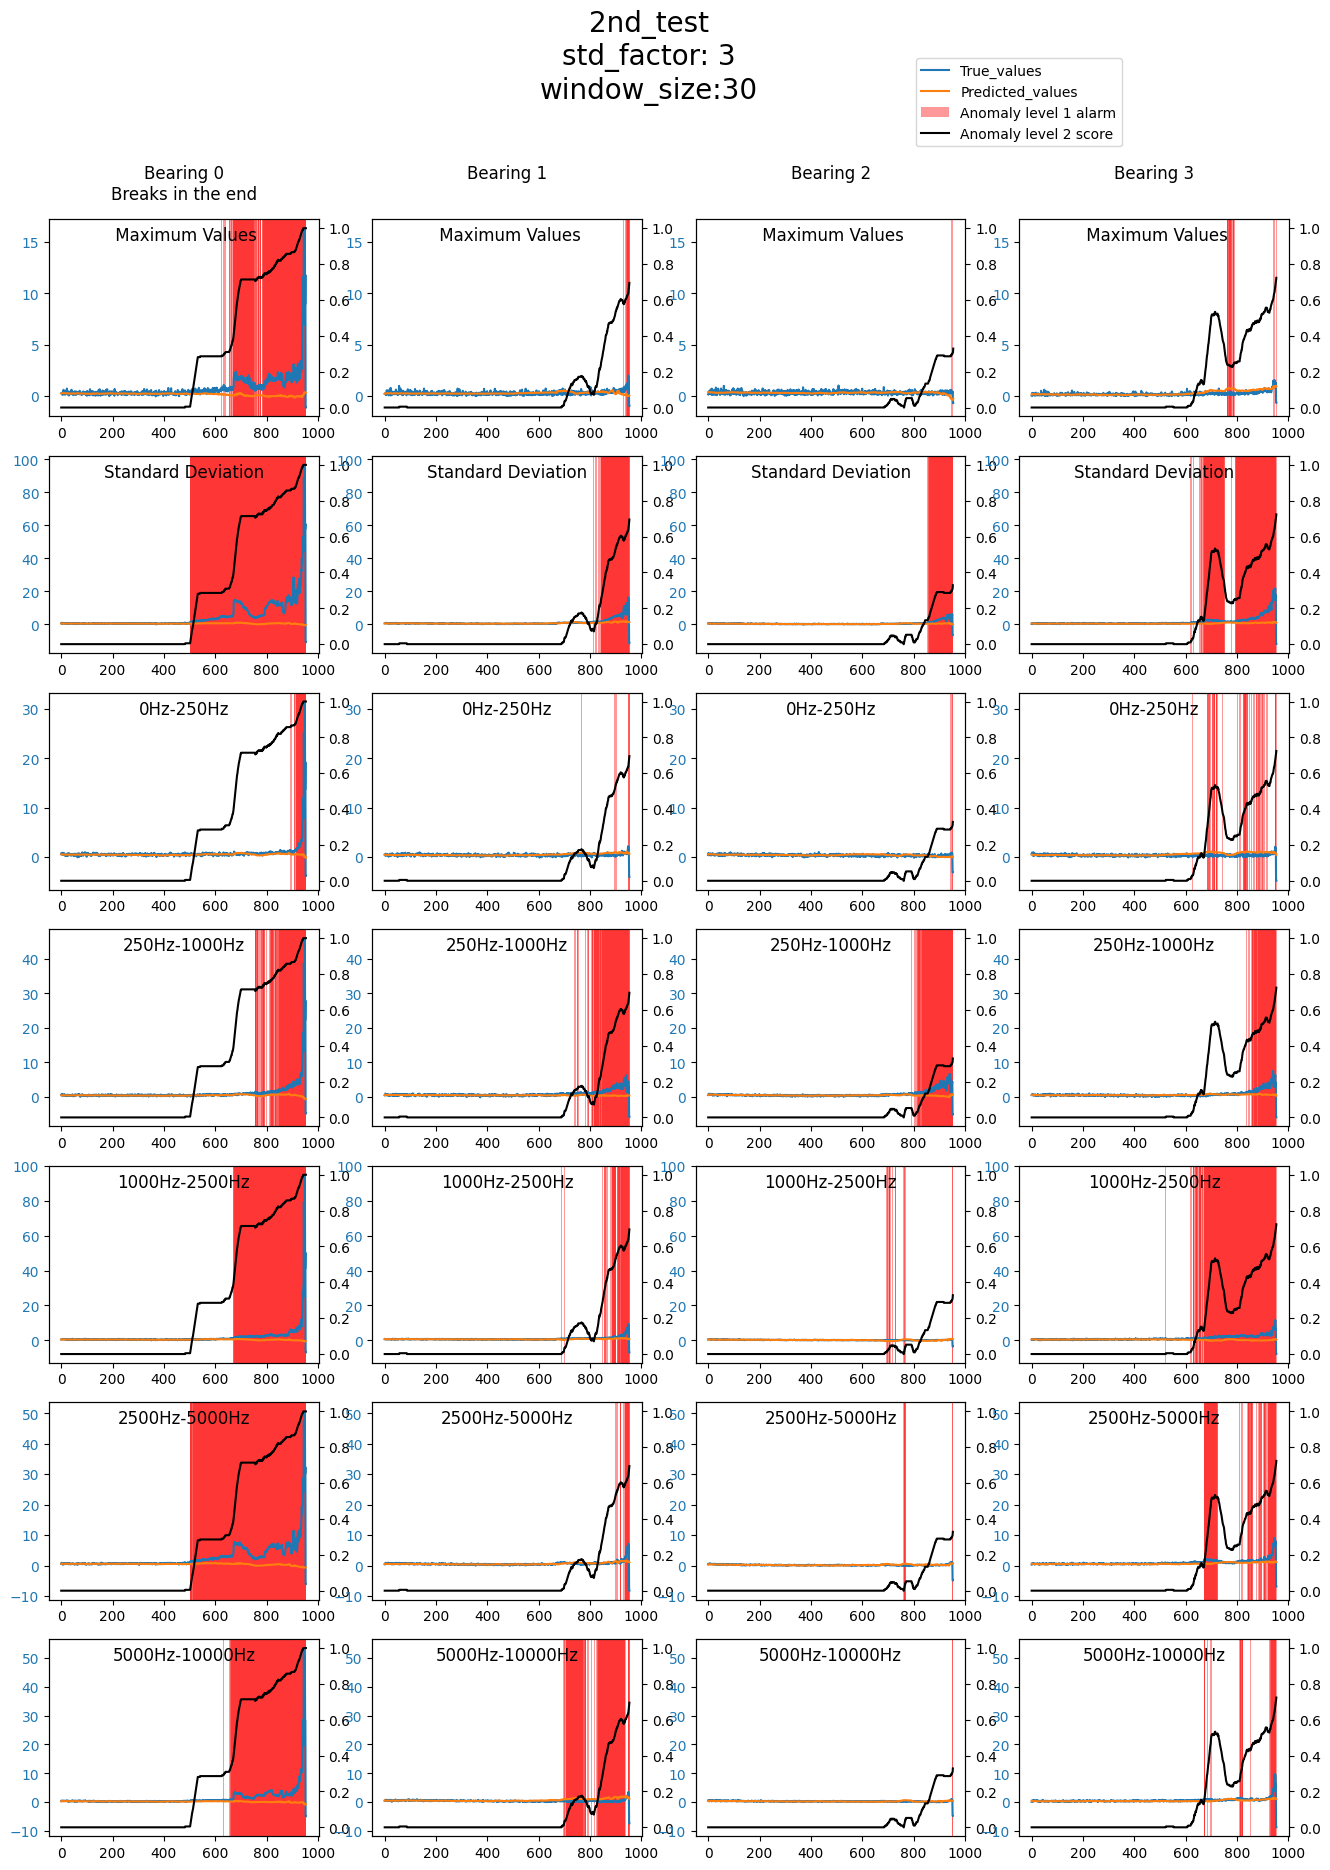

In [ ]:
test=1
X = np.concatenate((X_train_series_sub[test],X_test_series_sub[test]))
y_true = np.concatenate((y_train[test],y_test[test]))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = evaluate(cnn_lstm, X, y_true, test_size ,test, slice_to_plot=np.s_[:],anomaly_1_factor=3, window_size=30,
show_y_pred=True, show_anomaly1 = True, show_anomaly2 = True)

Mô hình dự đoán (đường màu cam) và giá trị thực tế (đường màu xanh) có sự chênh lệch đáng kể ở cuối dãy thời gian, đặc biệt là với Vòng bi 0 và Vòng bi 3, nơi có sự gia tăng lớn về giá trị và độ lệch chuẩn. Điều này cho thấy mô hình có khả năng dự đoán chính xác trước khi gặp phải bất thường. Các vùng màu đỏ biểu thị báo động bất thường cấp 1 và 2, với Vòng bi 3 có báo động nhiều và rõ ràng nhất, có thể là dấu hiệu của sự cố cơ khí sắp xảy ra hoặc đã xảy ra.

1/1 [==============================] - 3s 3s/step


Generating sequences: 100%|########################################| 30/30 [00:00<00:00, 637.02it/s]

2nd level alarm over 0.5:
[6149 6150 6151 6152 6153 6154 6155 6156 6157 6158]
[6171 6172 6173 6174 6175 6176 6177 6178 6179 6180]
[5959 5960 5961 5962 5963 5964 5965 5966 5967 5968]
[6246 6247 6248 6249 6250 6251 6252 6253 6254 6255]
Plotting


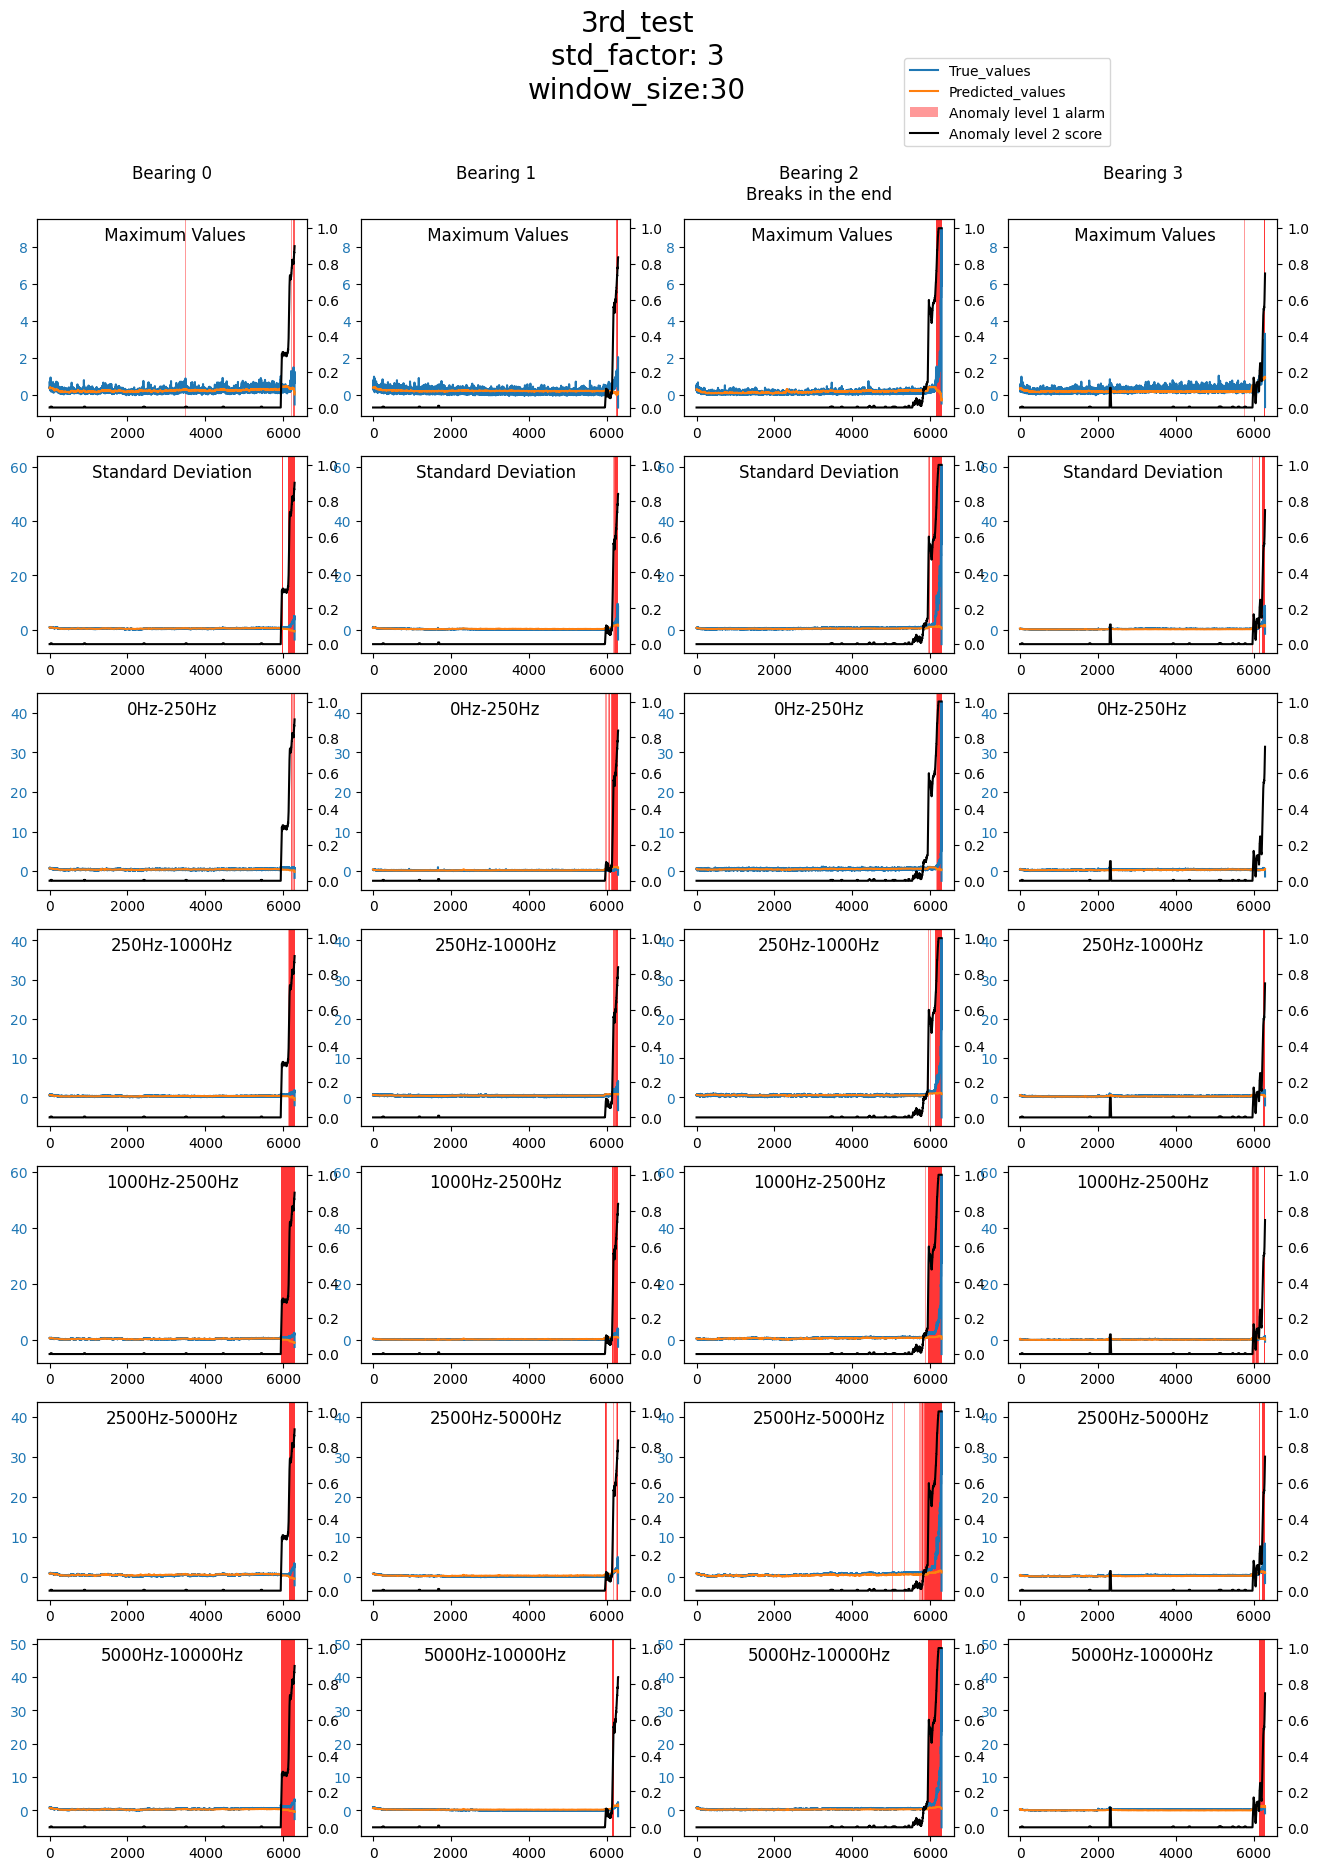

In [ ]:
test=2
X = np.concatenate((X_train_series_sub[test],X_test_series_sub[test]))
y_true = np.concatenate((y_train[test],y_test[test]))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = evaluate(cnn_lstm, X, y_true, test_size ,test, slice_to_plot=np.s_[:],anomaly_1_factor=3, window_size=30,
show_y_pred=True, show_anomaly1 = True, show_anomaly2 = True)

# Phân tích và đánh giá chung


Từ các kết quả test từ 0 đến 2, mô hình dự đoán cho thấy khả năng phát hiện bất thường tốt ở cuối chuỗi thời gian trên tất cả các vòng bi. Những bất thường này có thể liên quan đến sự cố cơ khí hoặc hỏng hóc và thường được biểu hiện qua sự tăng đột ngột của giá trị tối đa và độ lệch chuẩn. Mô hình có vẻ đáng tin cậy trong việc dự đoán dữ liệu trong điều kiện bình thường nhưng gặp khó khăn khi có biến động lớn, điều này là một yếu tố quan trọng trong việc bảo dưỡng dự đoán và giám sát trạng thái máy móc. Các báo động bất thường cấp độ 1 và 2 đều phản ánh được điều này, giúp nhận diện và ưu tiên các tình huống cần được kiểm tra chi tiết hơn.

In [ ]:
# Lưu mô hình dưới dạng file .keras
cnn_lstm.save('model_DSP_cnn_lstm.keras')

In [ ]:
# Lưu mô hình dưới dạng file .h5
cnn_lstm.save('model_DSP_cnn_lstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
